#Aris Tsilifonis sdi1700170 - Artificial Intelligence 2 (NLP with deep learning)
###Develop a sentiment classifier with 3 classes (pro-vax, anti-vax, neutral) using a bidirectional stacked RNN with LSTM/GRU cells for the Twitter vaccine sentiment dataset of the previous two assignments.For the development of the models, you can experiment with the number of stacked RNNs, the number of hidden layers, type of cells, skip connections, gradient clipping and dropout probability. Document the performance of different configurations on your final report. Use the Adam optimizer and the cross-entropy loss function. You should also utilize GloVe pre-trained word embeddings as the embeddings of the inputs of your models.


###1.Import necessary libraries for the project

In [1]:
!python -m textblob.download_corpora
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Best parameters during classification
from sklearn.model_selection import GridSearchCV
# Data preprocessing
from sklearn.model_selection import train_test_split
# Validation of the model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import torchtext
from torchtext.legacy import data
# For NN models
import torch.nn as nn
import torch
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
# For large and multi-dimensional arrays
import numpy as np
# For basic cleaning and data preprocessing 
import re
# For data manipulation and analysis
import pandas as pd
# Stop words
import nltk 
nltk.download('stopwords')  
#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import scipy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Necessary for data format
from sklearn.feature_extraction.text import CountVectorizer
# Word embedings
from sklearn.feature_extraction.text import TfidfVectorizer  
# Machine learning model
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data] Error downloading 'movie_reviews' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-
[nltk_data]     pages/packages/corpora/movie_reviews.zip>:   HTTP
[nltk_data]     Error 500: Internal Server Error
Finished.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/st

###2.Load train and validations datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv("/content/drive/My Drive/torchtext_data/train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13579 entries, 0 to 13578
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   13579 non-null  object
 1   label   13579 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 212.3+ KB


In [4]:
df_valid = pd.read_csv("/content/drive/My Drive/torchtext_data/valid.csv")
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2282 non-null   object
 1   label   2282 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.8+ KB


In [5]:
df_test = pd.read_csv("/content/drive/My Drive/torchtext_data/test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2397 non-null   object
 1   label   2397 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


###3.Set the seed, define the Fields and get the train/test/validation splits.

We'll be using packed padded sequences.In this way, RNN will only process the not padded elements of our sequence, and for any padded element we will have zero tensor for the output value. In order to use packed padded sequences in our RNN, we have to define how long the actual sequences are.By setting include_lengths = True for  TWEET field. Then batch.tweet will be a tuple with the first element being a text (a converted numerical tensor that has been padded) and the second element being the actual lengths of our tweets.

In [6]:
import random
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
TWEET = data.Field(tokenize = 'spacy', include_lengths=True)

LABEL = data.LabelField(dtype = torch.long)

# define which fiels we are going to process
train_val_fields = [('tweet', TWEET),('label', LABEL)] # process it as tweet,label


In [8]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False):
        examples = []
        # iterate all the rows in order to create the dataset dict
        for _, row in df.iterrows():
            label = row.label 
            tweet = row.tweet
            examples.append(data.Example.fromlist([tweet, label], fields))

        super().__init__(examples, fields)

    # class method in order to return the dataset in an apropriate from
    @classmethod
    def splits(cls, fields, train_df, test_df=None,valid_df=None):
        train_data, test_data,valid_data = (None, None,None)

        train_data = cls(train_df.copy(), fields)
        test_data = cls(test_df.copy(), fields, True)
        valid_data = cls(valid_df.copy(), fields, True)

        return tuple(d for d in (train_data, test_data,valid_data))

In [9]:
train_df, test_df , valid_df = DataFrameDataset.splits(train_val_fields, train_df=df_train, test_df=df_test,valid_df=df_valid)

In [10]:
print(f"TRAINING: \t {len(train_df)}")
print(f"TESTING: \t {len(test_df)}")
print(f"VALIDATION: \t {len(valid_df)}")

TRAINING: 	 13579
TESTING: 	 2397
VALIDATION: 	 2282


In [11]:
print(vars(train_df[1]))

{'tweet': ['learn', 'about', 'smallpox', 'in', 'class', 'and', 'the', 'picture', 'of', 'these', 'poor', 'baby', 'be', 'break', 'my', 'heart', 'vaccines', 'be', 'not', 'the', 'enemy', 'protect', 'your', 'kid'], 'label': 2}


###4.Load glove vectors , build our vocabulary and create the dataset iterators
Instead of having our word embeddings initialized randomly, initialize them with these pre-trained vectors.

Becaause we want to initialize to zero not only words in our vocabulary but also pretrained embeddings , we set unk_init = torch.Tensor.normal_. They will get parametrized via a Gaussian distribution.

In [12]:
MAX_VOCAB_SIZE = 25_000
TWEET.build_vocab(
    train_df,
    max_size = MAX_VOCAB_SIZE,
    vectors= "glove.6B.100d",
    unk_init = torch.Tensor.normal_
)
LABEL.build_vocab(train_df)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18918.68it/s]


In [13]:
LABEL.vocab.stoi

defaultdict(None, {0: 0, 1: 2, 2: 1})

In [14]:
BATCH_SIZE = 64

train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits(
    (train_df, valid_df, test_df),
    batch_size = BATCH_SIZE,
    device = device,sort_within_batch=True,
    sort_key = lambda x: len(x.tweet)
)

##5.Create bidirectional Recurrent Neural Network stacked with LSTM cell 
### Structure

By usinng LSTM RNN instead of standard RNN we are getting rid of [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
LSTM  solve this by having an extra recurrent state called a cell,c( the "memory" of the LSTM ) and it multiple gates which control the flow of information in and out of the memory.
### Bidirectional

The concept of bidirectional RNN is that we are having an RNN processing the words in the sentence from the first to the last (forward) and a second RNN processing(backward the words in the tweet.We make our prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), and the last hidden state from the backward RNN (gained from the first word of the sentence).
### Multi-layer(Stacked)
The idea is that we have additional RNNs on top of the initial standard RNN. The hidden state output by the downside RNN at time-step  t  will be the input to the RNN upperside one . The prediction is then made from the final hidden state of the final top layer.
### Rugularization

As we know from theory, the more parameters you have inside your model, the higher the probability that  model will overfit (low training error but high validation/testing error,ex. bad for new examples).To face that, we use a method of regularization called dropout. Dropout works by randomly dropping out (set as 0) neurons in a layer during a forward pass. 

### Details
The index of our token will be passed to the embeded layer in order to specify to the model that padding token wont determine the sentiment.

The size of the input  layer is the double the size of the hidden layer because we include forward and backward structure.

Dropout was created by setting a dropout layer(probability of dropping neurons),
within the forward method after each layer we want to apply dropout to.

We are passing the lengths of our sentences to be able to use packed padded sequences for our tweets.We then unpack the output sequence to transform it from a packed sequence to a tensor(with pack.padded.sequence).

Because want the upper layer with forward and backward hidden states, we get the top two hidden layers from the first dimension and then weconcatenate them to a tensor in order to return it from the forward method.

In [15]:
class RNNLSTM(nn.Module):
  def __init__(self, voc_size, embed_dim, hidden_dim, out_dim, n_layers, 
                bidir, dropout, pad_idx):
    super(RNNLSTM, self).__init__()

    self.embeds = nn.Embedding(voc_size, embedding_dim=embed_dim, padding_idx=pad_idx)
    self.lstm = nn.LSTM(embed_dim, hidden_size=hidden_dim, 
                        bidirectional=bidir, dropout=dropout,
                        num_layers=n_layers)
    self.fc = nn.Linear(2 * hidden_dim, out_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, txt, txt_lengths):
    
    embeddedsq = self.dropout(self.embeds(txt))
    
    packed_embeds = nn.utils.rnn.pack_padded_sequence(embeddedsq, txt_lengths.to('cpu'), enforce_sorted=False)
    packed_out, (a,b) = self.lstm(packed_embeds)
    
    out, out_lengths = nn.utils.rnn.pad_packed_sequence(packed_out)
    a = self.dropout(torch.cat((a[-2,:,:], a[-1,:,:]), dim = 1))        
        
    return self.fc(a)

In [16]:
import torch.nn as nn
from torch.nn import  functional as F

In [17]:
input_d = len(TWEET.vocab) # # 25002
embedding_d = 100#same as dimension of glove vectors
hidden_d = 256
output_d = len(LABEL.vocab.stoi)
layers_num = 2
bidirectional = True
dropout = 0.5
padding = TWEET.vocab.stoi[TWEET.pad_token] # 0

model = RNNLSTM(input_d, 
            embedding_d, 
            hidden_d, 
            output_d, 
            layers_num, 
            bidirectional, 
            dropout , 
            padding)
model

RNNLSTM(
  (embeds): Embedding(21668, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has  {count_trainable_params(model):,} trainable parameters')

The model has  4,478,483 trainable parameters


In [19]:
pretrained_embeddings = TWEET.vocab.vectors

We then replace the initial weights of the embedding layer with the pretrained embeddings

In [20]:
model.embeds.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.5005,  0.2531,  1.8303,  ...,  0.5205,  0.6098,  0.8963],
        [-1.8683,  0.1008, -0.1267,  ...,  0.3982,  0.7209,  0.0699],
        [ 0.1696,  1.4828, -1.0430,  ...,  2.0104,  0.0652, -0.7285]])

Unk and pad token are not responsible for producing the output.We should initialize them both to zero to explicitly define that to out model.

In [21]:
for i in range(2):
  model.embeds.weight.data[i] = torch.zeros(embedding_d)

model.embeds.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.5005,  0.2531,  1.8303,  ...,  0.5205,  0.6098,  0.8963],
        [-1.8683,  0.1008, -0.1267,  ...,  0.3982,  0.7209,  0.0699],
        [ 0.1696,  1.4828, -1.0430,  ...,  2.0104,  0.0652, -0.7285]])

Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates.

In [22]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [23]:
model = model.to(device)
criterion = criterion.to(device)

Calculate percentage of accuracy

We calculate the accuracy based on the sklearn library (precision,recall,f1)

Measure time

In [24]:
import time
def epoch_time(t1, t2):
    time_el = t2 - start_time
    minutes_el = int(time_el / 60)
    sec_el = int(time_el - (minutes_el * 60))
    return minutes_el, sec_el

Train and test with epochs

In [25]:
def train(modelx, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_f1 = 0
    epoch_acc_rec = 0
    epoch_acc_prec = 0
    modelx.train()
    for batch in iterator:
        optimizer.zero_grad()
        tweet, tweet_lengths = batch.tweet
        #target = torch.autograd.Variable(target).long()
        #print(tweet)
        predictions = modelx(tweet, tweet_lengths).squeeze(-1)
        #print(predictions)
        loss = criterion(predictions, batch.label)
        predictions = torch.argmax(predictions,dim=1).cpu()  
        var = batch.label.cpu()
        acc = precision_recall_fscore_support( predictions,var, average='weighted',warn_for=tuple())
        loss.backward()
        # Clip params
        for param in modelx.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -5, 5)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc_prec += acc[0]
        epoch_acc_rec += acc[1]
        epoch_acc_f1 += acc[2]

    return epoch_loss / len(iterator), epoch_acc_prec / len(iterator),epoch_acc_rec / len(iterator),epoch_acc_f1 / len(iterator)

def evaluate(modelx, iterator, criterion):
    epoch_loss = 0
    epoch_acc_f1 = 0
    epoch_acc_rec = 0
    epoch_acc_prec = 0
    modelx.eval()
    with torch.no_grad():
        for batch in iterator:
            tweet, tweet_lengths = batch.tweet
            predictions = modelx(tweet, tweet_lengths).squeeze(-1)
            loss = criterion(predictions, batch.label)
            predictions = torch.argmax(predictions,dim=1).cpu()  
            var = batch.label.cpu()
            acc = precision_recall_fscore_support( predictions, var, average='weighted',warn_for=tuple())
            epoch_loss += loss.item()
            epoch_acc_prec += acc[0]
            epoch_acc_rec += acc[1]
            epoch_acc_f1 += acc[2]

    return epoch_loss / len(iterator), epoch_acc_prec / len(iterator),epoch_acc_rec / len(iterator),epoch_acc_f1 / len(iterator)


In [26]:

N_EPOCHS = 8
best_valid_loss = float('inf')
losslist = []
losslist2 = []
train_epoch_acc_f1 = 0
train_epoch_acc_rec = 0
train_epoch_acc_prec = 0
valid_epoch_acc_f1 = 0
valid_epoch_acc_rec = 0
valid_epoch_acc_prec = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_epoch_acc_prec ,train_epoch_acc_rec ,train_epoch_acc_f1  = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_epoch_acc_prec ,valid_epoch_acc_rec ,valid_epoch_acc_f1  = evaluate(model, validation_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losslist.append(train_loss)
    losslist2.append(valid_loss)
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'best-model1.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Precision: {train_epoch_acc_prec*100:.2f}  | Train Recall: {train_epoch_acc_prec*100:.2f}  | Train F1: {train_epoch_acc_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Precision: {valid_epoch_acc_prec*100:.2f}  | Val. Recall: {valid_epoch_acc_prec*100:.2f}  | Val.  F1: {valid_epoch_acc_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.897 | Train Precision: 73.80  | Train Recall: 73.80  | Train F1: 62.13%
	 Val. Loss: 0.783 |  Val. Precision: 80.38  | Val. Recall: 80.38  | Val.  F1: 68.73%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.772 | Train Precision: 73.56  | Train Recall: 73.56  | Train F1: 67.67%
	 Val. Loss: 0.713 |  Val. Precision: 76.83  | Val. Recall: 76.83  | Val.  F1: 71.27%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.705 | Train Precision: 74.56  | Train Recall: 74.56  | Train F1: 70.46%
	 Val. Loss: 0.663 |  Val. Precision: 74.04  | Val. Recall: 74.04  | Val.  F1: 71.35%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.649 | Train Precision: 76.15  | Train Recall: 76.15  | Train F1: 73.13%
	 Val. Loss: 0.643 |  Val. Precision: 74.17  | Val. Recall: 74.17  | Val.  F1: 72.50%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.606 | Train Precision: 77.11  | Train Recall: 77.11  | Train F1: 74.87%
	 Val. Loss: 0.630 |  Val. Precision: 75.69  | Val. Recall: 75.69  | Va

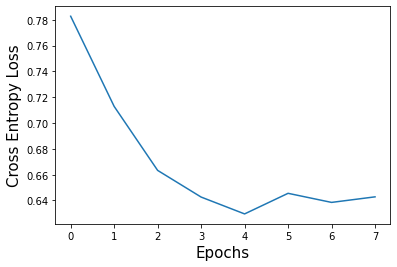

In [27]:
plt.plot(losslist2)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.show()

Improved accuracy on testing set

In [28]:
model.load_state_dict(torch.load('best-model1.pt'))

test_epoch_acc_f1 = 0
test_epoch_acc_rec = 0
test_epoch_acc_prec = 0
test_loss, test_epoch_acc_prec,test_epoch_acc_rec,test_epoch_acc_f1 = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Val. Precision: {test_epoch_acc_prec*100:.2f}  | Val. Recall: {test_epoch_acc_prec*100:.2f}  | Val.  F1: {test_epoch_acc_f1*100:.2f}%')

Test Loss: 0.641 |  Val. Precision: 75.29  | Val. Recall: 75.29  | Val.  F1: 73.00%


GRU is impemented in a similar way, but this time pack_padded_sequence is not returning cells.

In [29]:
class RNNGRU(nn.Module):
  def __init__(self, voc_size, embed_dim, hidden_dim, out_dim, n_layers, 
                bidir, dropout, pad_idx):
    super(RNNGRU, self).__init__()

    self.embeds = nn.Embedding(voc_size, embedding_dim=embed_dim, padding_idx=pad_idx)
    self.gru = nn.GRU(embed_dim, hidden_size=hidden_dim, 
                        bidirectional=bidir, dropout=dropout,
                        num_layers=n_layers)
    self.fc = nn.Linear(2 * hidden_dim, out_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, txt, txt_lengths):
   
    embeddedsq = self.dropout(self.embeds(txt))
    
    packed_embeds = nn.utils.rnn.pack_padded_sequence(embeddedsq, txt_lengths.to('cpu'), enforce_sorted=False)
    packed_out, a = self.gru(packed_embeds)
    
    #unpack sequence
    out, out_lengths = nn.utils.rnn.pad_packed_sequence(packed_out)
    a = self.dropout(torch.cat((a[-2,:,:], a[-1,:,:]), dim = 1))        
       
    return self.fc(a)

In [30]:
input_d = len(TWEET.vocab) # # 25002
embedding_d = 100#same as dimension of glove vectors
hidden_d = 256
output_d = len(LABEL.vocab.stoi)
layers_num = 2
bidirectional = True
dropout = 0.5
padding = TWEET.vocab.stoi[TWEET.pad_token] # 0

model2 = RNNGRU(input_d, 
            embedding_d, 
            hidden_d, 
            output_d, 
            layers_num, 
            bidirectional, 
            dropout , 
            padding)
model2

RNNGRU(
  (embeds): Embedding(21668, 100, padding_idx=1)
  (gru): GRU(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [31]:
def count_trainable_params(model):
  return sum(p.numel() for p in model2.parameters() if p.requires_grad)

print(f'The model has  {count_trainable_params(model2):,} trainable parameters')

The model has  3,900,947 trainable parameters


In [32]:
model2.embeds.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.5005,  0.2531,  1.8303,  ...,  0.5205,  0.6098,  0.8963],
        [-1.8683,  0.1008, -0.1267,  ...,  0.3982,  0.7209,  0.0699],
        [ 0.1696,  1.4828, -1.0430,  ...,  2.0104,  0.0652, -0.7285]])

In [33]:
for i in range(2):
  model2.embeds.weight.data[i] = torch.zeros(embedding_d)

model2.embeds.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.5005,  0.2531,  1.8303,  ...,  0.5205,  0.6098,  0.8963],
        [-1.8683,  0.1008, -0.1267,  ...,  0.3982,  0.7209,  0.0699],
        [ 0.1696,  1.4828, -1.0430,  ...,  2.0104,  0.0652, -0.7285]])

In [34]:
optimizer = torch.optim.Adam(model2.parameters())
model2 = model2.to(device)
criterion = criterion.to(device)

In [35]:
N_EPOCHS = 8
best_valid_loss = float('inf')
losslist3 = []
losslist4 = []
train_epoch_acc_f1 = 0
train_epoch_acc_rec = 0
train_epoch_acc_prec = 0
valid_epoch_acc_f1 = 0
valid_epoch_acc_rec = 0
valid_epoch_acc_prec = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_epoch_acc_prec ,train_epoch_acc_rec ,train_epoch_acc_f1  = train(model2, train_iterator, optimizer, criterion)
    valid_loss, valid_epoch_acc_prec ,valid_epoch_acc_rec ,valid_epoch_acc_f1  = evaluate(model2, validation_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losslist3.append(train_loss)
    losslist4.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'best-model2.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Precision: {train_epoch_acc_prec*100:.2f}  | Train Recall: {train_epoch_acc_prec*100:.2f}  | Train F1: {train_epoch_acc_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Precision: {valid_epoch_acc_prec*100:.2f}  | Val. Recall: {valid_epoch_acc_prec*100:.2f}  | Val.  F1: {valid_epoch_acc_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.895 | Train Precision: 69.73  | Train Recall: 69.73  | Train F1: 61.40%
	 Val. Loss: 0.777 |  Val. Precision: 76.84  | Val. Recall: 76.84  | Val.  F1: 69.99%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.778 | Train Precision: 72.66  | Train Recall: 72.66  | Train F1: 67.45%
	 Val. Loss: 0.728 |  Val. Precision: 74.60  | Val. Recall: 74.60  | Val.  F1: 69.06%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.715 | Train Precision: 74.22  | Train Recall: 74.22  | Train F1: 70.56%
	 Val. Loss: 0.694 |  Val. Precision: 71.76  | Val. Recall: 71.76  | Val.  F1: 69.59%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.665 | Train Precision: 75.75  | Train Recall: 75.75  | Train F1: 72.78%
	 Val. Loss: 0.683 |  Val. Precision: 77.01  | Val. Recall: 77.01  | Val.  F1: 71.57%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.610 | Train Precision: 77.77  | Train Recall: 77.77  | Train F1: 75.20%
	 Val. Loss: 0.665 |  Val. Precision: 78.52  | Val. Recall: 78.52  | Va

In [36]:
model2.load_state_dict(torch.load('best-model2.pt'))

test_epoch_acc_f1 = 0
test_epoch_acc_rec = 0
test_epoch_acc_prec = 0
test_loss, test_epoch_acc_prec,test_epoch_acc_rec,test_epoch_acc_f1 = evaluate(model2, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Val. Precision: {test_epoch_acc_prec*100:.2f}  | Val. Recall: {test_epoch_acc_prec*100:.2f}  | Val.  F1: {test_epoch_acc_f1*100:.2f}%')

Test Loss: 0.639 |  Val. Precision: 75.99  | Val. Recall: 75.99  | Val.  F1: 74.42%


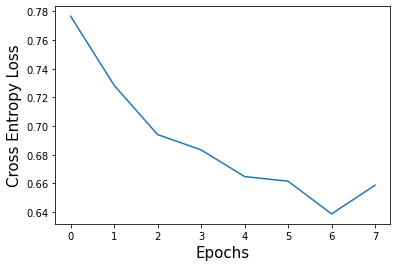

In [37]:
plt.plot(losslist4)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.show()

##Multiheaded Attention implementation

I created an additional layer for attention which I initialized the model with.I am dropping some neurons for each one layer as it imporves efficacy of the model.I pass the output of the model to the multiheaded attention in order to compute the output based on the specific weights that it produces.Num of heads must be divisable with hidden dim.I chosed multi headed attention because it does all of the difficult computations(with the masks etc.) on the background.
I encountered problems with the returned output of the model because it was much greater than expected.I chosed the first value of the prediction because it was the most consistently produced value of the model.I did't change anything else from previous implementations.As you will see below, it improves accuracy of the model by almost 1-2%).

In [38]:
class RNNLSTMA(nn.Module):
  def __init__(self, voc_size, embed_dim, hidden_dim, out_dim, n_layers, 
                bidir, dropout, pad_idx):
    super(RNNLSTMA, self).__init__()

    self.embeds = nn.Embedding(voc_size, embedding_dim=embed_dim, padding_idx=pad_idx)
    self.lstma = nn.LSTM(embed_dim, hidden_size=hidden_dim, 
                        bidirectional=bidir, dropout=dropout,
                        num_layers=n_layers)
    self.mha = nn.MultiheadAttention(2*hidden_dim, num_heads = 8)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(2 * hidden_dim, out_dim) 
    self.dropout = nn.Dropout(dropout)

  def forward(self, txt, txt_lengths):
    embeddedsq = self.dropout(self.embeds(txt))
    
    packed_embeds = nn.utils.rnn.pack_padded_sequence(embeddedsq, txt_lengths.to('cpu'), enforce_sorted=False)
    packed_out, (a,b) = self.lstma(packed_embeds)
    
    out, out_lengths = nn.utils.rnn.pad_packed_sequence(packed_out)
    
    attn_output, attn_output_weights = self.mha(out, out, out)   

    return self.fc(attn_output)

In [39]:
input_d = len(TWEET.vocab) # # 25002
embedding_d = 100#same as dimension of glove vectors
hidden_d = 256
output_d = len(LABEL.vocab.stoi)
layers_num = 2
bidirectional = True
dropout = 0.5
padding = TWEET.vocab.stoi[TWEET.pad_token] # 0

model3 = RNNLSTMA(input_d, 
            embedding_d, 
            hidden_d, 
            output_d, 
            layers_num, 
            bidirectional, 
            dropout , 
            padding)
model3

RNNLSTMA(
  (embeds): Embedding(21668, 100, padding_idx=1)
  (lstma): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [40]:
def count_trainable_params(model):
  return sum(p.numel() for p in model3.parameters() if p.requires_grad)

print(f'The model has  {count_trainable_params(model3):,} trainable parameters')

The model has  5,529,107 trainable parameters


In [41]:
model3.embeds.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.5005,  0.2531,  1.8303,  ...,  0.5205,  0.6098,  0.8963],
        [-1.8683,  0.1008, -0.1267,  ...,  0.3982,  0.7209,  0.0699],
        [ 0.1696,  1.4828, -1.0430,  ...,  2.0104,  0.0652, -0.7285]])

In [42]:
optimizer = torch.optim.Adam(model3.parameters())
model3 = model3.to(device)

In [43]:
criterion = criterion.to(device)

In [44]:
for i in range(2):
  model3.embeds.weight.data[i] = torch.zeros(embedding_d)


In [45]:
model3.embeds.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.5005,  0.2531,  1.8303,  ...,  0.5205,  0.6098,  0.8963],
        [-1.8683,  0.1008, -0.1267,  ...,  0.3982,  0.7209,  0.0699],
        [ 0.1696,  1.4828, -1.0430,  ...,  2.0104,  0.0652, -0.7285]],
       device='cuda:0')

In [46]:
def train2(modely, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_f1 = 0
    epoch_acc_rec = 0
    epoch_acc_prec = 0
    modely.train()
    for batch in iterator:
        optimizer.zero_grad()
        tweet, tweet_lengths = batch.tweet
        predictions = modely(tweet, tweet_lengths).squeeze(1)
        loss = criterion(predictions[0], batch.label)
        var = torch.argmax(predictions[0],dim=1).cpu()  
        batch.label = batch.label.cpu()
        acc = precision_recall_fscore_support( var,batch.label, average='weighted',warn_for=tuple())
        loss.backward()
        # Clip params
        for param in modely.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -5, 5)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc_prec += acc[0]
        epoch_acc_rec += acc[1]
        epoch_acc_f1 += acc[2]

    return epoch_loss / len(iterator), epoch_acc_prec / len(iterator),epoch_acc_rec / len(iterator),epoch_acc_f1 / len(iterator)

def evaluate2(modely, iterator, criterion):
    epoch_loss = 0
    epoch_acc_f1 = 0
    epoch_acc_rec = 0
    epoch_acc_prec = 0
    modely.eval()
    with torch.no_grad():
        for batch in iterator:
            tweet, tweet_lengths = batch.tweet
            predictions = modely(tweet, tweet_lengths).squeeze(1)
            loss = criterion(predictions[0], batch.label)
            var = torch.argmax(predictions[0],dim=1).cpu()  
            batch.label = batch.label.cpu()
            acc = precision_recall_fscore_support( var, batch.label, average='weighted',warn_for=tuple())
            epoch_loss += loss.item()
            epoch_acc_prec += acc[0]
            epoch_acc_rec += acc[1]
            epoch_acc_f1 += acc[2]

    return epoch_loss / len(iterator), epoch_acc_prec / len(iterator),epoch_acc_rec / len(iterator),epoch_acc_f1 / len(iterator)

In [47]:
N_EPOCHS = 6
best_valid_loss = float('inf')
losslist5 = []
losslist6 = []
train_epoch_acc_f1 = 0
train_epoch_acc_rec = 0
train_epoch_acc_prec = 0
valid_epoch_acc_f1 = 0
valid_epoch_acc_rec = 0
valid_epoch_acc_prec = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_epoch_acc_prec ,train_epoch_acc_rec ,train_epoch_acc_f1  = train2(model3, train_iterator, optimizer, criterion)
    valid_loss, valid_epoch_acc_prec ,valid_epoch_acc_rec ,valid_epoch_acc_f1  = evaluate2(model3, validation_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losslist5.append(train_loss)
    losslist6.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model3.state_dict(), 'best-model3.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Precision: {train_epoch_acc_prec*100:.2f}  | Train Recall: {train_epoch_acc_prec*100:.2f}  | Train F1: {train_epoch_acc_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Precision: {valid_epoch_acc_prec*100:.2f}  | Val. Recall: {valid_epoch_acc_prec*100:.2f}  | Val.  F1: {valid_epoch_acc_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.883 | Train Precision: 75.32  | Train Recall: 75.32  | Train F1: 63.33%
	 Val. Loss: 0.775 |  Val. Precision: 76.44  | Val. Recall: 76.44  | Val.  F1: 67.50%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.770 | Train Precision: 73.56  | Train Recall: 73.56  | Train F1: 67.98%
	 Val. Loss: 0.697 |  Val. Precision: 76.40  | Val. Recall: 76.40  | Val.  F1: 70.83%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.701 | Train Precision: 75.31  | Train Recall: 75.31  | Train F1: 70.78%
	 Val. Loss: 0.675 |  Val. Precision: 75.69  | Val. Recall: 75.69  | Val.  F1: 72.19%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.661 | Train Precision: 77.01  | Train Recall: 77.01  | Train F1: 73.21%
	 Val. Loss: 0.706 |  Val. Precision: 80.19  | Val. Recall: 80.19  | Val.  F1: 73.95%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.610 | Train Precision: 78.10  | Train Recall: 78.10  | Train F1: 75.22%
	 Val. Loss: 0.644 |  Val. Precision: 74.44  | Val. Recall: 74.44 

In [48]:
model3.load_state_dict(torch.load('best-model3.pt'))

test_epoch_acc_f1 = 0
test_epoch_acc_rec = 0
test_epoch_acc_prec = 0
test_loss, test_epoch_acc_prec,test_epoch_acc_rec,test_epoch_acc_f1 = evaluate2(model3, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test. Precision: {test_epoch_acc_prec*100:.2f}  | Test. Recall: {test_epoch_acc_prec*100:.2f}  | Test.  F1: {test_epoch_acc_f1*100:.2f}%')

Test Loss: 0.647 |  Test. Precision: 76.08  | Test. Recall: 76.08  | Test.  F1: 73.57%


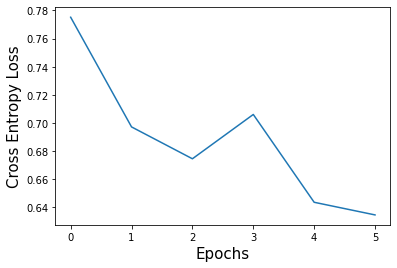

In [49]:
plt.plot(losslist6)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.show()

My stratagy in order to value accuracy of the models was to find the best f1 score for each model(bacause we have inbalanced dataset - very small sample of class 1 ).After that , I realized the best scores were quite similar for the epochs above.Then I started to value the precision scores so as to judge which model produces better results.

##Experimentation with models

Tuning hyperparameters such as learning rate in optimizer and number of epochs

LSTM

In [50]:
input_d = len(TWEET.vocab) # # 25002
embedding_d = 100#same as dimension of glove vectors
hidden_d = 256
output_d = len(LABEL.vocab.stoi)
layers_num = 2
bidirectional = True
dropout = 0.5
padding = TWEET.vocab.stoi[TWEET.pad_token] # 0

model4 = RNNLSTM(input_d, 
            embedding_d, 
            hidden_d, 
            output_d, 
            layers_num, 
            bidirectional, 
            dropout , 
            padding)
model4


RNNLSTM(
  (embeds): Embedding(21668, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [51]:
def count_trainable_params(modelx):
  return sum(p.numel() for p in modelx.parameters() if p.requires_grad)

print(f'The model has  {count_trainable_params(model4):,} trainable parameters')
model4.embeds.weight.data.copy_(pretrained_embeddings)
optimizer = torch.optim.Adam(model4.parameters())
model4 = model4.to(device)
criterion = criterion.to(device)
for i in range(2):
  model4.embeds.weight.data[i] = torch.zeros(embedding_d)
model4.embeds.weight.data
optimizer = torch.optim.Adam(model4.parameters(),lr=0.03)
model4 = model4.to(device)

The model has  4,478,483 trainable parameters


In [52]:
N_EPOCHS = 15
best_valid_loss = float('inf')
losslist7 = []
losslist8 = []
train_epoch_acc_f1 = 0
train_epoch_acc_rec = 0
train_epoch_acc_prec = 0
valid_epoch_acc_f1 = 0
valid_epoch_acc_rec = 0
valid_epoch_acc_prec = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_epoch_acc_prec ,train_epoch_acc_rec ,train_epoch_acc_f1  = train(model4, train_iterator, optimizer, criterion)
    valid_loss, valid_epoch_acc_prec ,valid_epoch_acc_rec ,valid_epoch_acc_f1  = evaluate(model4, validation_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losslist7.append(train_loss)
    losslist8.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model4.state_dict(), 'best-model4.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Precision: {train_epoch_acc_prec*100:.2f}  | Train Recall: {train_epoch_acc_prec*100:.2f}  | Train F1: {train_epoch_acc_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Precision: {valid_epoch_acc_prec*100:.2f}  | Val. Recall: {valid_epoch_acc_prec*100:.2f}  | Val.  F1: {valid_epoch_acc_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 1.130 | Train Precision: 67.98  | Train Recall: 67.98  | Train F1: 50.43%
	 Val. Loss: 1.072 |  Val. Precision: 95.76  | Val. Recall: 95.76  | Val.  F1: 56.17%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 1.013 | Train Precision: 63.23  | Train Recall: 63.23  | Train F1: 54.11%
	 Val. Loss: 1.004 |  Val. Precision: 85.32  | Val. Recall: 85.32  | Val.  F1: 58.46%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 1.207 | Train Precision: 56.17  | Train Recall: 56.17  | Train F1: 51.24%
	 Val. Loss: 1.226 |  Val. Precision: 48.14  | Val. Recall: 48.14  | Val.  F1: 43.51%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 1.761 | Train Precision: 47.02  | Train Recall: 47.02  | Train F1: 43.05%
	 Val. Loss: 1.501 |  Val. Precision: 69.05  | Val. Recall: 69.05  | Val.  F1: 48.65%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 1.666 | Train Precision: 46.44  | Train Recall: 46.44  | Train F1: 42.60%
	 Val. Loss: 2.020 |  Val. Precision: 71.56  | Val. Recall: 71.56  | Va

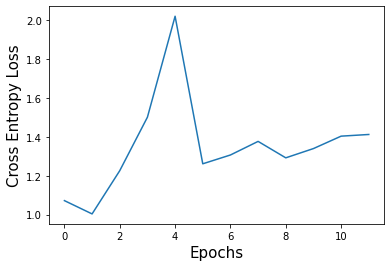

In [53]:
plt.plot(losslist8)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.show()

In [54]:
model4.load_state_dict(torch.load('best-model4.pt'))

test_epoch_acc_f1 = 0
test_epoch_acc_rec = 0
test_epoch_acc_prec = 0
test_loss, test_epoch_acc_prec,test_epoch_acc_rec,test_epoch_acc_f1 = evaluate(model4, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test. Precision: {test_epoch_acc_prec*100:.2f}  | Test. Recall: {test_epoch_acc_prec*100:.2f}  | Test.  F1: {test_epoch_acc_f1*100:.2f}%')

Test Loss: 0.977 |  Test. Precision: 86.26  | Test. Recall: 86.26  | Test.  F1: 60.90%


In [55]:
input_d = len(TWEET.vocab) # # 25002
embedding_d = 100#same as dimension of glove vectors
hidden_d = 256
output_d = len(LABEL.vocab.stoi)
layers_num = 2
bidirectional = True
dropout = 0.5
padding = TWEET.vocab.stoi[TWEET.pad_token] # 0

model5 = RNNGRU(input_d, 
            embedding_d, 
            hidden_d, 
            output_d, 
            layers_num, 
            bidirectional, 
            dropout , 
            padding)
model5


RNNGRU(
  (embeds): Embedding(21668, 100, padding_idx=1)
  (gru): GRU(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [56]:
def count_trainable_params(modelx):
  return sum(p.numel() for p in modelx.parameters() if p.requires_grad)

print(f'The model has  {count_trainable_params(model5):,} trainable parameters')
model5.embeds.weight.data.copy_(pretrained_embeddings)
optimizer = torch.optim.Adam(model5.parameters())
model5 = model5.to(device)
criterion = criterion.to(device)
for i in range(2):
  model5.embeds.weight.data[i] = torch.zeros(embedding_d)
model5.embeds.weight.data
optimizer = torch.optim.Adam(model5.parameters(),lr=0.0015)
model5 = model5.to(device)

The model has  3,900,947 trainable parameters


In [57]:
N_EPOCHS = 15
best_valid_loss = float('inf')
losslist9 = []
losslist10 = []
train_epoch_acc_f1 = 0
train_epoch_acc_rec = 0
train_epoch_acc_prec = 0
valid_epoch_acc_f1 = 0
valid_epoch_acc_rec = 0
valid_epoch_acc_prec = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_epoch_acc_prec ,train_epoch_acc_rec ,train_epoch_acc_f1  = train(model5, train_iterator, optimizer, criterion)
    valid_loss, valid_epoch_acc_prec ,valid_epoch_acc_rec ,valid_epoch_acc_f1  = evaluate(model5, validation_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losslist9.append(train_loss)
    losslist10.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model5.state_dict(), 'best-model5.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Precision: {train_epoch_acc_prec*100:.2f}  | Train Recall: {train_epoch_acc_prec*100:.2f}  | Train F1: {train_epoch_acc_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Precision: {valid_epoch_acc_prec*100:.2f}  | Val. Recall: {valid_epoch_acc_prec*100:.2f}  | Val.  F1: {valid_epoch_acc_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.882 | Train Precision: 70.77  | Train Recall: 70.77  | Train F1: 62.43%
	 Val. Loss: 0.742 |  Val. Precision: 77.52  | Val. Recall: 77.52  | Val.  F1: 69.98%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.750 | Train Precision: 73.15  | Train Recall: 73.15  | Train F1: 68.64%
	 Val. Loss: 0.698 |  Val. Precision: 80.05  | Val. Recall: 80.05  | Val.  F1: 71.78%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.685 | Train Precision: 74.98  | Train Recall: 74.98  | Train F1: 71.61%
	 Val. Loss: 0.698 |  Val. Precision: 73.90  | Val. Recall: 73.90  | Val.  F1: 71.30%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.617 | Train Precision: 78.02  | Train Recall: 78.02  | Train F1: 75.39%
	 Val. Loss: 0.721 |  Val. Precision: 79.35  | Val. Recall: 79.35  | Val.  F1: 72.51%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.563 | Train Precision: 79.59  | Train Recall: 79.59  | Train F1: 77.32%
	 Val. Loss: 0.658 |  Val. Precision: 76.08  | Val. Recall: 76.08  | Va

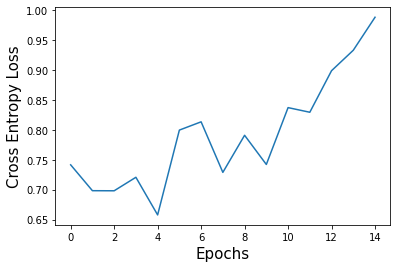

In [58]:
plt.plot(losslist10)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.show()

In [59]:
model5.load_state_dict(torch.load('best-model5.pt'))

test_epoch_acc_f1 = 0
test_epoch_acc_rec = 0
test_epoch_acc_prec = 0
test_loss, test_epoch_acc_prec,test_epoch_acc_rec,test_epoch_acc_f1 = evaluate(model5, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test. Precision: {test_epoch_acc_prec*100:.2f}  | Test. Recall: {test_epoch_acc_prec*100:.2f}  | Test.  F1: {test_epoch_acc_f1*100:.2f}%')

Test Loss: 0.672 |  Test. Precision: 76.07  | Test. Recall: 76.07  | Test.  F1: 73.85%


In [60]:
input_d = len(TWEET.vocab) # # 25002
embedding_d = 100#same as dimension of glove vectors
hidden_d = 512
output_d = len(LABEL.vocab.stoi)
layers_num = 2
bidirectional = True
dropout = 0.3
padding = TWEET.vocab.stoi[TWEET.pad_token] # 0

model6 = RNNLSTMA(input_d, 
            embedding_d, 
            hidden_d, 
            output_d, 
            layers_num, 
            bidirectional, 
            dropout , 
            padding)
model6


RNNLSTMA(
  (embeds): Embedding(21668, 100, padding_idx=1)
  (lstma): LSTM(100, 512, num_layers=2, dropout=0.3, bidirectional=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)

In [61]:
def count_trainable_params(modelx):
  return sum(p.numel() for p in modelx.parameters() if p.requires_grad)

print(f'The model has  {count_trainable_params(model6):,} trainable parameters')
model6.embeds.weight.data.copy_(pretrained_embeddings)
optimizer = torch.optim.Adam(model6.parameters())
model6 = model6.to(device)
criterion = criterion.to(device)
for i in range(2):
  model6.embeds.weight.data[i] = torch.zeros(embedding_d)
model6.embeds.weight.data
optimizer = torch.optim.Adam(model6.parameters())
model6 = model6.to(device)

The model has  15,182,867 trainable parameters


In [62]:
N_EPOCHS = 15
best_valid_loss = float('inf')
losslist11 = []
losslist12= []
train_epoch_acc_f1 = 0
train_epoch_acc_rec = 0
train_epoch_acc_prec = 0
valid_epoch_acc_f1 = 0
valid_epoch_acc_rec = 0
valid_epoch_acc_prec = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_epoch_acc_prec ,train_epoch_acc_rec ,train_epoch_acc_f1  = train2(model6, train_iterator, optimizer, criterion)
    valid_loss, valid_epoch_acc_prec ,valid_epoch_acc_rec ,valid_epoch_acc_f1  = evaluate2(model6, validation_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losslist11.append(train_loss)
    losslist12.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model6.state_dict(), 'best-model6.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Precision: {train_epoch_acc_prec*100:.2f}  | Train Recall: {train_epoch_acc_prec*100:.2f}  | Train F1: {train_epoch_acc_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Precision: {valid_epoch_acc_prec*100:.2f}  | Val. Recall: {valid_epoch_acc_prec*100:.2f}  | Val.  F1: {valid_epoch_acc_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.869 | Train Precision: 76.51  | Train Recall: 76.51  | Train F1: 64.75%
	 Val. Loss: 0.760 |  Val. Precision: 80.84  | Val. Recall: 80.84  | Val.  F1: 70.88%
Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.736 | Train Precision: 74.42  | Train Recall: 74.42  | Train F1: 69.18%
	 Val. Loss: 0.730 |  Val. Precision: 81.61  | Val. Recall: 81.61  | Val.  F1: 72.09%
Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.677 | Train Precision: 77.02  | Train Recall: 77.02  | Train F1: 72.58%
	 Val. Loss: 0.705 |  Val. Precision: 79.91  | Val. Recall: 79.91  | Val.  F1: 72.47%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.589 | Train Precision: 79.70  | Train Recall: 79.70  | Train F1: 76.72%
	 Val. Loss: 0.649 |  Val. Precision: 74.48  | Val. Recall: 74.48  | Val.  F1: 72.05%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.513 | Train Precision: 81.83  | Train Recall: 81.83  | Train F1: 79.88%
	 Val. Loss: 0.765 |  Val. Precision: 75.58  | Val. Recall: 75.58 

In [63]:
model6.load_state_dict(torch.load('best-model6.pt'))

test_epoch_acc_f1 = 0
test_epoch_acc_rec = 0
test_epoch_acc_prec = 0
test_loss, test_epoch_acc_prec,test_epoch_acc_rec,test_epoch_acc_f1 = evaluate2(model6, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test. Precision: {test_epoch_acc_prec*100:.2f}  | Test. Recall: {test_epoch_acc_prec*100:.2f}  | Test.  F1: {test_epoch_acc_f1*100:.2f}%')

Test Loss: 0.658 |  Test. Precision: 73.44  | Test. Recall: 73.44  | Test.  F1: 71.84%


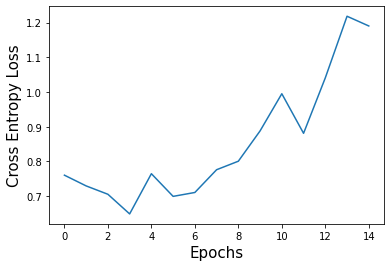

In [64]:
plt.plot(losslist12)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.show()

In [65]:
BATCH_SIZE = 512

train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits(
    (train_df, valid_df, test_df),
    batch_size = BATCH_SIZE,
    device = device,sort_within_batch=True,
    sort_key = lambda x: len(x.tweet)
)

In [66]:
input_d = len(TWEET.vocab) # # 25002
embedding_d = 100#same as dimension of glove vectors
hidden_d = 256
output_d = len(LABEL.vocab.stoi)
layers_num = 2
bidirectional = True
dropout = 0.7
padding = TWEET.vocab.stoi[TWEET.pad_token] # 0

model7 = RNNLSTMA(input_d, 
            embedding_d, 
            hidden_d, 
            output_d, 
            layers_num, 
            bidirectional, 
            dropout , 
            padding)
model7


RNNLSTMA(
  (embeds): Embedding(21668, 100, padding_idx=1)
  (lstma): LSTM(100, 256, num_layers=2, dropout=0.7, bidirectional=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [67]:
def count_trainable_params(modelx):
  return sum(p.numel() for p in modelx.parameters() if p.requires_grad)

print(f'The model has  {count_trainable_params(model4):,} trainable parameters')
model7.embeds.weight.data.copy_(pretrained_embeddings)
optimizer = torch.optim.Adam(model7.parameters())
model7 = model7.to(device)
criterion = criterion.to(device)
for i in range(2):
  model7.embeds.weight.data[i] = torch.zeros(embedding_d)
model7.embeds.weight.data
optimizer = torch.optim.Adam(model7.parameters())
model7 = model7.to(device)

The model has  4,478,483 trainable parameters


In [68]:
N_EPOCHS = 15
best_valid_loss = float('inf')
losslist13 = []
losslist14 = []
train_epoch_acc_f1 = 0
train_epoch_acc_rec = 0
train_epoch_acc_prec = 0
valid_epoch_acc_f1 = 0
valid_epoch_acc_rec = 0
valid_epoch_acc_prec = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_epoch_acc_prec ,train_epoch_acc_rec ,train_epoch_acc_f1  = train2(model7, train_iterator, optimizer, criterion)
    valid_loss, valid_epoch_acc_prec ,valid_epoch_acc_rec ,valid_epoch_acc_f1  = evaluate2(model7, validation_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losslist13.append(train_loss)
    losslist14.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model7.state_dict(), 'best-model7.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Precision: {train_epoch_acc_prec*100:.2f}  | Train Recall: {train_epoch_acc_prec*100:.2f}  | Train F1: {train_epoch_acc_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Precision: {valid_epoch_acc_prec*100:.2f}  | Val. Recall: {valid_epoch_acc_prec*100:.2f}  | Val.  F1: {valid_epoch_acc_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 1.049 | Train Precision: 89.97  | Train Recall: 89.97  | Train F1: 58.88%
	 Val. Loss: 0.986 |  Val. Precision: 71.25  | Val. Recall: 71.25  | Val.  F1: 59.84%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.931 | Train Precision: 68.47  | Train Recall: 68.47  | Train F1: 60.22%
	 Val. Loss: 0.890 |  Val. Precision: 73.09  | Val. Recall: 73.09  | Val.  F1: 65.17%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.888 | Train Precision: 72.52  | Train Recall: 72.52  | Train F1: 62.18%
	 Val. Loss: 0.850 |  Val. Precision: 67.16  | Val. Recall: 67.16  | Val.  F1: 63.49%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.851 | Train Precision: 70.67  | Train Recall: 70.67  | Train F1: 64.16%
	 Val. Loss: 0.857 |  Val. Precision: 72.97  | Val. Recall: 72.97  | Val.  F1: 65.77%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.824 | Train Precision: 70.85  | Train Recall: 70.85  | Train F1: 65.87%
	 Val. Loss: 0.804 |  Val. Precision: 76.18  | Val. Recall: 76.18  | Va

In [69]:
model7.load_state_dict(torch.load('best-model7.pt'))

test_epoch_acc_f1 = 0
test_epoch_acc_rec = 0
test_epoch_acc_prec = 0
test_loss, test_epoch_acc_prec,test_epoch_acc_rec,test_epoch_acc_f1 = evaluate2(model7, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test. Precision: {test_epoch_acc_prec*100:.2f}  | Test. Recall: {test_epoch_acc_prec*100:.2f}  | Test.  F1: {test_epoch_acc_f1*100:.2f}%')

Test Loss: 0.658 |  Test. Precision: 77.01  | Test. Recall: 77.01  | Test.  F1: 74.55%


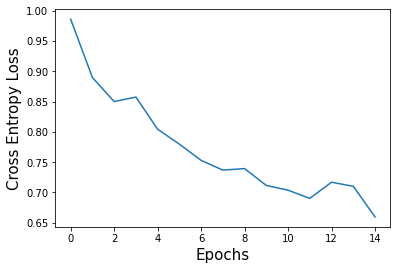

In [70]:
plt.plot(losslist14)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.show()

##Conclusion
###I observe that increasing the number of epochs is reducing the efficiency of the models(overfitting of the training set).Also , increasing or decreasing the learning rate doesn't play much role in the results of the models.Additional hidden dimension is not good for our model too.Another interesting observation is that LSTM with attention produces very high precision scores of the first two epochs of the training(on validation set).It could probably mean that batch size was helping enough in determining the accuracy on validation set.The problem is that f1 is quite low on that occasion(only 60%) and the loss is very high.It shows that those results are misleading and unreliable on that stage, so we need more epochs for better results.Finally , increasing the batch size is a little beneficial for the model's perfomance.In addition,reducing the droppout value to 0.3 is seen as not beneficial for the model's result.On the other hand , increasing that value to 0.7 is showing 1% better results.
###Comparing to the previous assignment , the results are slightly better (10% more accuracy with better f1 score) which is quite satisfying.The loss here is quite greater than the previous assignment , but this may be because I used BCE Loss on previous assignment and also I did not depend on validation set for the loss.Nevertheless, the results are obviously better here 

### Regarding the roc curve scores ,they are also better here.As you see below the roc score is 0.75 when previously was 0.7.As we know,classifiers that give curves closer to the top left corner indicate a better performance. The closer the curve comes to the 45 – degree diagonal of the ROC space , the less accurate the test. As we see at the notebook , the curves are acceptable .Moreover, the classifier produces better true positive rate for 1st class comparing to the other classes.As the area under an ROC curve is a measure of the usefulness of a test in general, where a greater area means a more useful test, the areas under ROC curves are used to compare the usefulness of tests.Class 1 curve covers more area.

##ROC Curve

In [71]:
def get_labels(model, iterator):

    list_ypred = []
    list_ytrue = []

    with torch.no_grad():
        model.eval()
        for batch in iterator:

            tweet, lengths = batch.tweet
            pred_y = model(tweet, lengths)
            true_y = batch.label.reshape(-1, 1)

            list_ypred.append(pred_y)
            list_ytrue.append(true_y)
    
    pred_y_full = torch.cat(list_ypred, dim=0).cpu()
    true_y_full = torch.cat(list_ytrue, dim=0).cpu()

    return true_y_full, pred_y_full

In [72]:
def one_hot_encoder(train_labels):
    onehot_encoded = list()
    for value in train_labels:
      letter = [float(0) for _ in range(3)]
      letter[int(value)] = float(1)
      onehot_encoded.append(letter)
    return np.array(onehot_encoded)

In [73]:
# get the true and predicted labels from the appropriate function
Y_test, predict_outs = get_labels(model, validation_iterator)

# calculate the fpr and tpr for all thresholds of the classification
probs = predict_outs.detach().numpy()

# keep probabilities for the positive outcome only
ns_probs = [[0,0,0] for _ in range(len(Y_test))]

Y_test_tensor =  torch.as_tensor(Y_test, dtype=torch.float32)
print(Y_test_tensor)
Y_testb = one_hot_encoder(Y_test_tensor)
Y_testb = torch.as_tensor(Y_testb, dtype=torch.float32)

print(Y_testb)
probs = torch.as_tensor(probs, dtype=torch.float32)
probs = torch.argmax(probs,dim=1)
probs = one_hot_encoder(probs)
print(probs)

ns_auc = roc_auc_score(Y_testb, ns_probs, multi_class="ovr")
lr_auc = roc_auc_score(Y_testb, probs, multi_class="ovr")

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))



tensor([[2.],
        [1.],
        [0.],
        ...,
        [0.],
        [2.],
        [0.]])
tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.756


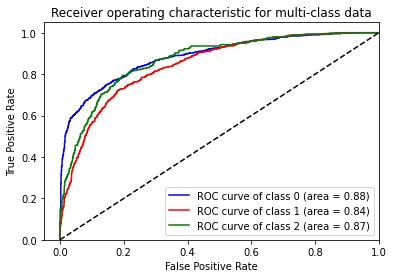

In [74]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

predict_outs = predict_outs.detach().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_testb[:, i],predict_outs[:, i] )
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()